In [1]:
import numpy as np
import matplotlib.pyplot as plt

from jax import jit, vmap, config
from jax.lax import cond
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as js
import jax.scipy.linalg as jsl

import numpyro
import numpyro.distributions as dist
from numpyro.infer.initialization import init_to_value

import sys
import os
sys.path.append(os.path.abspath('..'))

from PTA import PTA
from ent_likelihood import Likelihood
from samples import Samples
import constants as c

from ent_data_simulation import params_injected

import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth

from ent_data_simulation.pulsar_phase import get_psr_phase

import healpy as hp

# use double precision
config.update('jax_enable_x64', True)

%load_ext autoreload
%autoreload 2

In [2]:
# load Enterprise pulsar data
data_dict = np.load('ent_data_simulation/data/data_dict.npz', allow_pickle=True)
toas = jnp.array(data_dict['toas'])
residuals = jnp.array(data_dict['residuals'])
Tspans = toas[:, -1] - toas[:, 0]
Tspan = jnp.mean(Tspans)
Tspan_yr = Tspan / c.year_sec
Np = toas.shape[0]
Ntoas = toas.shape[1]
psr_pos = jnp.array(data_dict['psr_pos'])
psr_dists = jnp.array(data_dict['psr_dists'])
psr_dists_inj = psr_dists[0]
psr_dists_stdev = psr_dists[1]
Fs = jnp.array(data_dict['Fs'])
Ms = jnp.array(data_dict['Ms'])
Rs = jnp.array([jnp.eye(Ntoas) - M @ jnp.linalg.inv(M.T @ M) @ M.T
                for M in Ms])
U_s = jnp.array([jnp.linalg.svd(M)[0]
                 for M in Ms])
Gs = jnp.array([U[:, 8:] for U in U_s])
Ns = jnp.array(data_dict['Ns'])
Ntinvs = jnp.array([G @ jnp.linalg.inv(G.T @ N @ G) @ G.T
                    for G, N in zip(Gs, Ns)])
psr_names = data_dict['psr_names']
x_inj_dict = data_dict['x_inj'].item()

Np = toas.shape[0]
Ntoas = toas.shape[1]
Nf = params_injected.num_modes
Na = 2 * Nf

In [3]:
pta_for_params = PTA(Np=Np,
                     Tspan_yr=15,
                     Nf=params_injected.num_modes,
                     model_wn=False,
                     model_rn=params_injected.rn_model,
                     model_gwb=params_injected.gwb_model,
                     model_cw=params_injected.cw_model,
                     Enterprise_bounds=True,
                     Nf_cw=15,
                     tref=params_injected.tref)

In [4]:
if Fs.shape == (Np, Ntoas, 0):
    freqs = jnp.arange(1, Nf + 1) / Tspan
    Fs = jnp.zeros((Np, Ntoas, Na))
    for i in range(Np):
        for j in range(Nf):
            Fs = Fs.at[i, :, 2 * j].set(jnp.sin(2. * jnp.pi * \
                                                            freqs[j] * toas[i]))
            Fs = Fs.at[i, :, 2 * j + 1].set(jnp.cos(2. * jnp.pi * \
                                                                freqs[j] * toas[i]))

In [5]:
N_cw = 8
N_psr = 2 * Np
N_cw_psr = N_cw + N_psr
window_ext_yr = pta_for_params.window_ext_yr
Nf_cw = pta_for_params.Nf_cw
Na_cw = pta_for_params.Na_cw
from scipy.signal.windows import tukey


# window extension for CW FFT (avoids Gibbs phenomena)
window_ext_yr = window_ext_yr
window_ext = window_ext_yr * c.year_sec

# extended Tspan for CW FFT
Tspan_ext_yr = Tspan_yr + 2. * window_ext_yr
Tspan_ext = Tspan_ext_yr * c.year_sec

# sparse TOAs for CW FFT
sparse_toas_CW = jnp.array([jnp.linspace(toas[idx][0] - window_ext,
                                                toas[idx][-1] + window_ext,
                                                Na_cw + 2, endpoint=False)
                                    for idx in range(Np)])  # (Np, N_sparse)
Nsparse = sparse_toas_CW.shape[1]
freqs_forFFT = jnp.array([jnp.fft.fftfreq(Nsparse, Tspan_ext / Nsparse)
                                for _ in range(Np)])

# Fourier design matrix for CW
Fs_cw = jnp.zeros((Np, Ntoas, Na_cw))
for i in range(Np):
    for j in range(Nf_cw):
        Fs_cw = Fs_cw.at[i, :, 2 * j].set(jnp.sin(2. * jnp.pi * \
                                                    freqs_forFFT[i, j + 1] * toas[i]))
        Fs_cw = Fs_cw.at[i, :, 2 * j + 1].set(jnp.cos(2. * jnp.pi * \
                                                        freqs_forFFT[i, j + 1] * toas[i]))            

# Tukey window for FFT
Tukey_cw = tukey(Nsparse, alpha=window_ext_yr/Tspan_ext_yr)
Tukey_cw = jnp.array(Tukey_cw)

In [6]:
# antenna pattern for continuous waves
@jit
def create_gw_antenna_pattern(gwtheta, gwphi):
    '''
    Creates a continuous gravitational wave antenna pattern.

    param: gwtheta: theta coordinate for sky location of CW source
    param: gwphi: phi coordinate for sky location of CW source
    '''

    # use definition from Sesana et al 2010 and Ellis et al 2012
    sgwphi = jnp.sin(gwphi)
    cgwphi = jnp.cos(gwphi)
    sgwtheta = jnp.sin(gwtheta)
    cgwtheta = jnp.cos(gwtheta)

    mdotpos = sgwphi * psr_pos[:, 0] - cgwphi * psr_pos[:, 1]
    ndotpos = -cgwtheta * cgwphi * psr_pos[:, 0] - cgwtheta * sgwphi * psr_pos[:, 1] \
                + sgwtheta * psr_pos[:, 2]
    omhatdotpos = -sgwtheta * cgwphi * psr_pos[:, 0] - sgwtheta * sgwphi * psr_pos[:, 1] \
                    -cgwtheta * psr_pos[:, 2]

    fplus = 0.5 * (mdotpos ** 2 - ndotpos ** 2) / (1 + omhatdotpos)
    fcross = (mdotpos * ndotpos) / (1 + omhatdotpos)
    cosMu = -omhatdotpos

    return fplus, fcross, cosMu

In [7]:
# get signal due to continuous wave
def cw_delay(x_CW):
        # 
        #           psrTerm=True, p_dist=p_dist, p_phase=p_phase,
        #           phase_approx=True, check=False,
        #           tref=tref):


    # unpack parameters
    log10_mc, log10_fgw, cos_inc, psi, log10_dist, cos_gwtheta, gwphi, phase0 = x_CW[:N_cw]
    p_phases = x_CW[N_cw : N_cw + Np]
    pdists = x_CW[N_cw + Np:]

    # convert units to time
    mc = 10 ** log10_mc * c.Tsun
    fgw = 10 ** log10_fgw
    gwtheta = jnp.arccos(cos_gwtheta)
    inc = jnp.arccos(cos_inc)
    p_dists = pdists * c.kpc / c.c
    dist = 10 ** log10_dist * c.Mpc / c.c

    # get antenna pattern funcs and cosMu
    # write function to get pos from theta,phi
    fplus, fcross, cosMu = create_gw_antenna_pattern(gwtheta, gwphi)

    # get pulsar time
    toas_copy = sparse_toas_CW - params_injected.tref
    tp = toas_copy - (p_dists * (1 - cosMu))[:, None]

    # orbital frequency
    w0 = jnp.pi * fgw
    phase0 /= 2  # convert GW to orbital phase
    # omegadot = 96/5 * mc**(5/3) * w0**(11/3) # Not currently used in code

    # monochromatic
    omega = w0
    omega_p = w0 * (1 + 256/5
                    * mc**(5/3) * w0**(8/3) * p_dists*(1-cosMu))**(-3/8)

    # phases
    phase = phase0 + omega * toas_copy
    phase_p = phase0 + p_phases[:, None] + omega_p[:, None] * toas_copy


    # define time dependent coefficients
    At = -0.5*jnp.sin(2*phase)*(3+jnp.cos(2*inc))
    Bt = 2*jnp.cos(2*phase)*jnp.cos(inc)
    At_p = -0.5*jnp.sin(2*phase_p)*(3+jnp.cos(2*inc))
    Bt_p = 2*jnp.cos(2*phase_p)*jnp.cos(inc)

    # now define time dependent amplitudes
    alpha = mc**(5./3.)/(dist*omega**(1./3.))
    alpha_p = mc**(5./3.)/(dist*omega_p**(1./3.))[:, None]

    # define rplus and rcross
    rplus = alpha*(-At*jnp.cos(2*psi)+Bt*jnp.sin(2*psi))
    rcross = alpha*(At*jnp.sin(2*psi)+Bt*jnp.cos(2*psi))
    rplus_p = alpha_p*(-At_p*jnp.cos(2*psi)+Bt_p*jnp.sin(2*psi))
    rcross_p = alpha_p*(At_p*jnp.sin(2*psi)+Bt_p*jnp.cos(2*psi))

    # residuals
    res = fplus[:, None]*(rplus_p-rplus)+fcross[:, None]*(rcross_p-rcross)
    
    return res

# get Fourier coefficients for CW signal in all pulsars
@jit
def get_CW_coefficients(x_CW):
    '''
    Use FFT to get Fourier coefficients for CW residuals given CW parameters.

    params: x_CW: continuous wave parameters
    '''
    cw_residuals = cw_delay(x_CW)
    # window residuals over window
    cw_residuals_windowed = Tukey_cw * cw_residuals
    # cw_residuals_windowed = cw_residuals
    # do FFT
    cw_fft = jnp.fft.fft(cw_residuals_windowed, n=None, axis=-1, norm=None)  # dim (Np, 2 * Nf + 2)
    # apply time shift to fft to set initial time
    cw_fft *= jnp.exp(-1.j * 2 * jnp.pi * freqs_forFFT * sparse_toas_CW[:, 0:1])
    
    # extract sine and cosine coefficients
    a_n = jnp.imag(cw_fft[:, :Nsparse // 2]) * (-2 / Nsparse)  # (Np, Nf + 1)
    b_n = jnp.real(cw_fft[:, :Nsparse // 2]) * (2 / Nsparse)  # (Np, Nf + 1)
    coeff = jnp.concatenate((a_n, b_n), axis=1).reshape((Np, 2, Nf_cw + 1))\
                            .transpose((0, 2, 1)).reshape((Np, Na_cw + 2))
    return coeff[:, 2:]  # remove DC

In [8]:
rho_scales = []
arrs = []
for Tspan in Tspans:
    rho_scale = (c.year_sec ** 3.) / (12. * (jnp.pi ** 2.) * Tspan)
    rho_scale1 = Tspan / c.year_sec
    arr = jnp.repeat(jnp.arange(1, Nf + 1), 2)
    arr /= rho_scale1
    arr = jnp.array(arr)
    rho_scales.append(rho_scale)
    arrs.append(arr)
rho_scales = jnp.array(rho_scales)
arrs = jnp.array(arrs)


@jit
def get_rho_diag(hyper_params, rho_scale, arr):
    logAmp, gamma = hyper_params
    Amp = 10. ** logAmp
    return (Amp ** 2.) * rho_scale * (arr **  (-gamma))

vectorized_get_rho_diag_full_input = jit(vmap(get_rho_diag, in_axes=(0, 0, 0)))

@jit
def vectorized_get_rho_diag(hyper_params):
    return vectorized_get_rho_diag_full_input(hyper_params, rho_scales, arrs)

In [9]:
psr_phases = jnp.array([get_psr_phase(params_injected.CW_params_inj, pos, distance)
                        for pos, distance in zip(psr_pos, psr_dists_inj)])
x_cw_psr_inj = jnp.concatenate((params_injected.CW_params_inj, psr_phases, jnp.array(psr_dists_inj)))
cw_inj = jnp.array([R @ F @ a for R, F, a in zip(Rs, Fs_cw, get_CW_coefficients(x_cw_psr_inj))])
rn_inj = jnp.array([res - cw for res, cw in zip(residuals, cw_inj)])
a_rn_ML = jnp.array([jnp.linalg.pinv(F) @ rn for F, rn in zip(Fs, rn_inj)]).flatten()

In [10]:
init_dict = {'rn_hypers':jnp.array(params_injected.RN_hypers_inj),
             'cw': jnp.array(params_injected.CW_params_inj),
             'psr_dists':jnp.array(psr_dists_inj),
             'psr_phases': jnp.array([get_psr_phase(params_injected.CW_params_inj, pos, distance)
                                      for pos, distance in zip(psr_pos, psr_dists_inj)])}

x_inj_arr = jnp.concatenate((init_dict['rn_hypers'],
                             init_dict['cw'],
                             init_dict['psr_phases'],
                             init_dict['psr_dists'],
                             a_rn_ML))

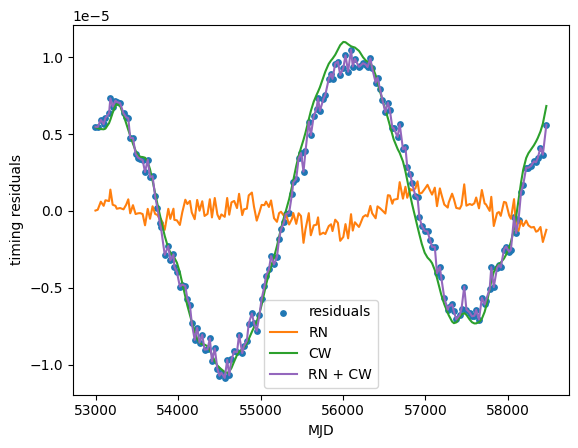

In [11]:
psr_ndx = 4
plt.scatter(toas[psr_ndx] / 86400., residuals[psr_ndx], color='C0', label='residuals', s=15)
plt.plot(toas[psr_ndx] / 86400., Rs[psr_ndx] @ rn_inj[psr_ndx],
         color='C1', label='RN')
plt.plot(toas[psr_ndx] / 86400., Rs[psr_ndx] @ cw_inj[psr_ndx],
         color='C2', label='CW')
plt.plot(toas[psr_ndx] / 86400., Rs[psr_ndx] @ (cw_inj + rn_inj)[psr_ndx],
         color='C4', label='RN + CW')
# plt.scatter(sparse_toas_CW[psr_ndx] / 86400., cw_delay(x_inj_arr)[psr_ndx], color='k')
plt.legend()
plt.xlabel('MJD')
plt.ylabel('timing residuals')
plt.show()

In [12]:
efacs = jnp.ones(Np)

Us = jnp.array([res.T @ Ntinv @ res for res, Ntinv in zip(residuals,
                                                                Ntinvs)])
Vs = jnp.array([F.T @ Ntinv @ res for F, Ntinv, res in zip(Fs,
                                                                Ntinvs,
                                                                residuals)])
Ws = jnp.array([F.T @ Ntinv @ F for F, Ntinv in zip(Fs,
                                                            Ntinvs)])
Vs_cw = jnp.array([F.T @ Ntinv @ res for F, Ntinv, res in zip(Fs_cw,
                                                                Ntinvs,
                                                                residuals)])
Ws_cw = jnp.array([F.T @ Ntinv @ F for F, Ntinv in zip(Fs_cw,
                                                            Ntinvs)])
Ws_tilde = jnp.array([F.T @ Ntinv @ F_cw for F, Ntinv, F_cw in zip(Fs,
                                                            Ntinvs, Fs_cw)])

In [13]:
@jit
def lnlike_per_psr_cwbasis(efac, a_rn_gwb, a_cw, U, V, W, V_cw, W_cw, W_tilde):
    lnlike_val = U + a_rn_gwb.T @ W @ a_rn_gwb - 2 * jnp.inner(a_rn_gwb, V)
    lnlike_val += -2. * jnp.inner(a_cw, V_cw) + 2. * a_rn_gwb.T @ W_tilde @ a_cw + a_cw.T @ W_cw @ a_cw
    lnlike_val *= -0.5 / efac**2.
    lnlike_val +=  -(Ntoas) * jnp.log(efac)
    return lnlike_val

vectorized_lnlike_per_psr_cwbasis = jit(vmap(lnlike_per_psr_cwbasis, in_axes=(0, 0, 0, 0, 0, 0, 0, 0, 0)))

# likelihood for all pulsars when CW uses different basis
@jit
def lnlike_cwbasis(efacs, a_rn_gwb, a_cw):
    a_rn_gwb_stacked = a_rn_gwb.reshape((Np, Na))
    a_cw_stacked = a_cw.reshape((Np, Na_cw))
    return jnp.sum(vectorized_lnlike_per_psr_cwbasis(efacs,
                                                    a_rn_gwb_stacked,
                                                    a_cw_stacked,
                                                    Us,
                                                    Vs,
                                                    Ws,
                                                    Vs_cw,
                                                    Ws_cw,
                                                    Ws_tilde))

In [14]:
@jit
def uniform_lnprior(x):
    out_of_bounds = jnp.logical_or(jnp.any(x < pta_for_params.x_mins),
                                   jnp.any(x > pta_for_params.x_maxs))
    def out_of_bounds_case():
        return -jnp.inf
    def in_bounds_case():
        return 0.
    return cond(out_of_bounds, out_of_bounds_case, in_bounds_case)

In [15]:
@jit
def lnpost(x):
    
    # unpack parameters
    rn_hypers = x[pta_for_params.rn_ndxs]
    a = x[pta_for_params.a_ndxs]
    x_cw_psr = x[pta_for_params.cw_psr_ndxs]
    psr_dists = x[pta_for_params.psr_dist_ndxs]

    # get diagonal of prior for Fourier coefficients
    rho_diag = vectorized_get_rho_diag(rn_hypers.reshape((Np, 2))).flatten()

    # priors
    lnprior_val = uniform_lnprior(x)
    lnprior_val += jnp.sum(js.stats.norm.logpdf(psr_dists, psr_dists_inj, psr_dists_stdev))
    lnprior_val += -0.5 * jnp.sum(a**2. / rho_diag) - 0.5 * jnp.sum(jnp.log(rho_diag))

    # likelihood
    a_cw = get_CW_coefficients(x_cw_psr)
    lnlike_val = lnlike_cwbasis(efacs, a, a_cw)
    return lnlike_val + lnprior_val

vectorized_lnpost = jit(vmap(lnpost))

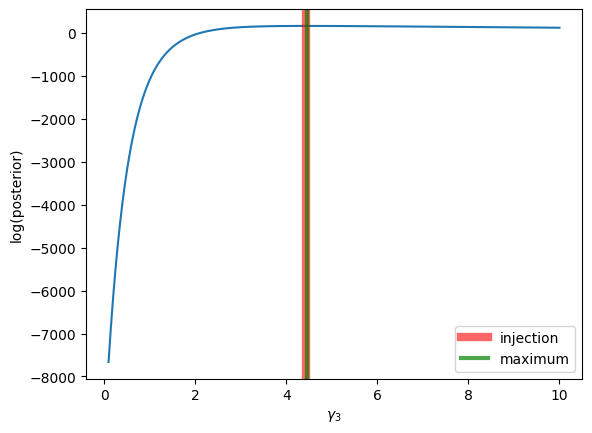

In [16]:
# plot cross-section of posterior
param_ndx = 5
num_evals = 1000
param_vals = jnp.linspace(pta_for_params.x_mins[param_ndx], pta_for_params.x_maxs[param_ndx], num_evals)
params = jnp.tile(x_inj_arr, (num_evals, 1))
params = params.at[:, param_ndx].set(param_vals)
lnposts = vectorized_lnpost(params)

plt.plot(param_vals, lnposts)
plt.axvline(pta_for_params.x_inj[param_ndx], color='red', label='injection', lw=6, alpha=0.6)
plt.axvline(param_vals[jnp.argmax(lnposts)], color='green', label='maximum', lw=3, alpha=0.7)
plt.legend()
plt.xlabel(pta_for_params.x_labels[param_ndx])
plt.ylabel('log(posterior)')
plt.show()

In [17]:
def sampling_model():
    rn_hypers = numpyro.sample('rn_hypers', dist.Uniform(pta_for_params.rn_mins,
                                                         pta_for_params.rn_maxs))
    diag_cov = vectorized_get_rho_diag(rn_hypers.reshape((Np, 2))).flatten()
    a_standard = numpyro.sample('a_standard', dist.Normal().expand((pta_for_params.Na_PTA,)))
    a = a_standard * jnp.sqrt(diag_cov)
    numpyro.deterministic('a', a)

    cw = numpyro.sample('cw', dist.Uniform(pta_for_params.x_mins[pta_for_params.cw_ndxs],
                                           pta_for_params.x_maxs[pta_for_params.cw_ndxs]))
    psr_phases = numpyro.sample('psr_phases', dist.Uniform(pta_for_params.x_mins[pta_for_params.psr_phase_ndxs],
                                                           pta_for_params.x_maxs[pta_for_params.psr_phase_ndxs]))
    psr_dists_standard = numpyro.sample('psr_dists_standard', dist.Normal().expand((Np,)))
    psr_dists = psr_dists_inj + psr_dists_standard * psr_dists_stdev
    numpyro.deterministic('psr_dists', psr_dists)
    a_cw = get_CW_coefficients(jnp.concatenate((cw, psr_phases, psr_dists)))

    # likelihood
    numpyro.factor('ln_likelihood', lnlike_cwbasis(efacs, a, a_cw))

In [19]:
nuts_kernel = numpyro.infer.NUTS(sampling_model,
                                 # dense_mass=True,
                                 dense_mass=[('rn_hypers',), ('cw',)],
                                 init_strategy=init_to_value(values=init_dict),
                                 # max_tree_depth=10,
                                 # find_heuristic_step_size=True,
                                 )
mcmc = numpyro.infer.MCMC(sampler=nuts_kernel,
                          num_warmup=int(5e3),
                          num_samples=int(3e4))
mcmc.run(jr.key(1112))
samples_dict = mcmc.get_samples()

sample: 100%|██████████| 35000/35000 [28:09<00:00, 20.72it/s, 1023 steps of size 1.19e-03. acc. prob=0.91]


In [20]:
# convert dictionary of samples into array
samples = np.concatenate((samples_dict['rn_hypers'],
                          samples_dict['cw'],
                          samples_dict['psr_phases'],
                          samples_dict['psr_dists'],
                          samples_dict['a']),
                          axis=1)

In [21]:
hmc_samples = Samples(samples_arr=samples,
                      labels=pta_for_params.x_labels,
                      x_inj=x_inj_arr,
                      lnpost_func=lnpost,
                      jax=True)

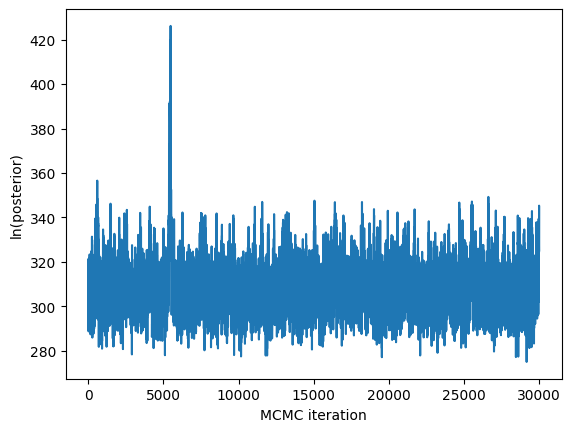

In [22]:
hmc_samples.plt_posterior_vals(plt_inj=False)

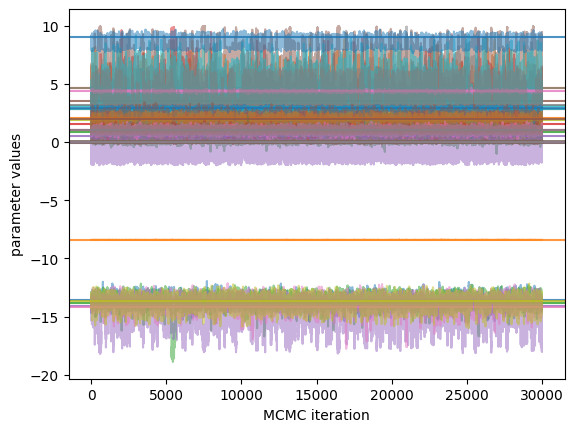

In [23]:
hmc_samples.trace_plt()

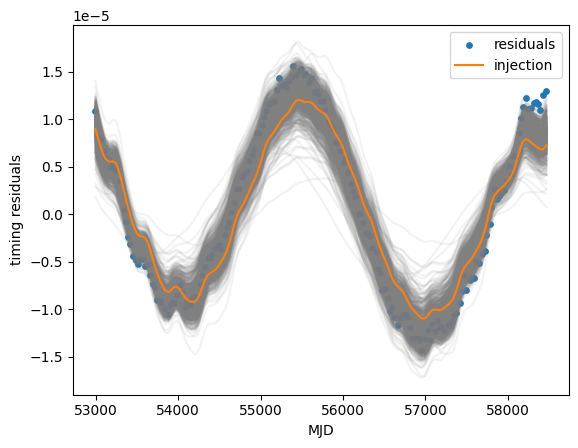

In [24]:
psr_ndx = 0
num_draws = 1000
draw_ndxs = np.random.choice(hmc_samples.samples.shape[0], (num_draws,))
plt.scatter(toas[psr_ndx] / 86400., residuals[psr_ndx], color='C0', label='residuals', s=15)
_ = [plt.plot(toas[psr_ndx] / 86400., Rs[psr_ndx] @ Fs_cw[psr_ndx] @ \
              get_CW_coefficients(samp[pta_for_params.cw_psr_ndxs])[psr_ndx],
              color='grey', alpha=0.1)
     for samp in samples[draw_ndxs]]
plt.plot(toas[psr_ndx] / 86400., Rs[psr_ndx] @ Fs_cw[psr_ndx] @ get_CW_coefficients(x_cw_psr_inj)[psr_ndx],
         color='C1', label='injection')
plt.legend()
plt.xlabel('MJD')
plt.ylabel('timing residuals')
plt.show()

In [72]:
# load samples from Enterprise run
ent_df = pd.read_pickle("ent_df.pkl.gz", compression="gzip")

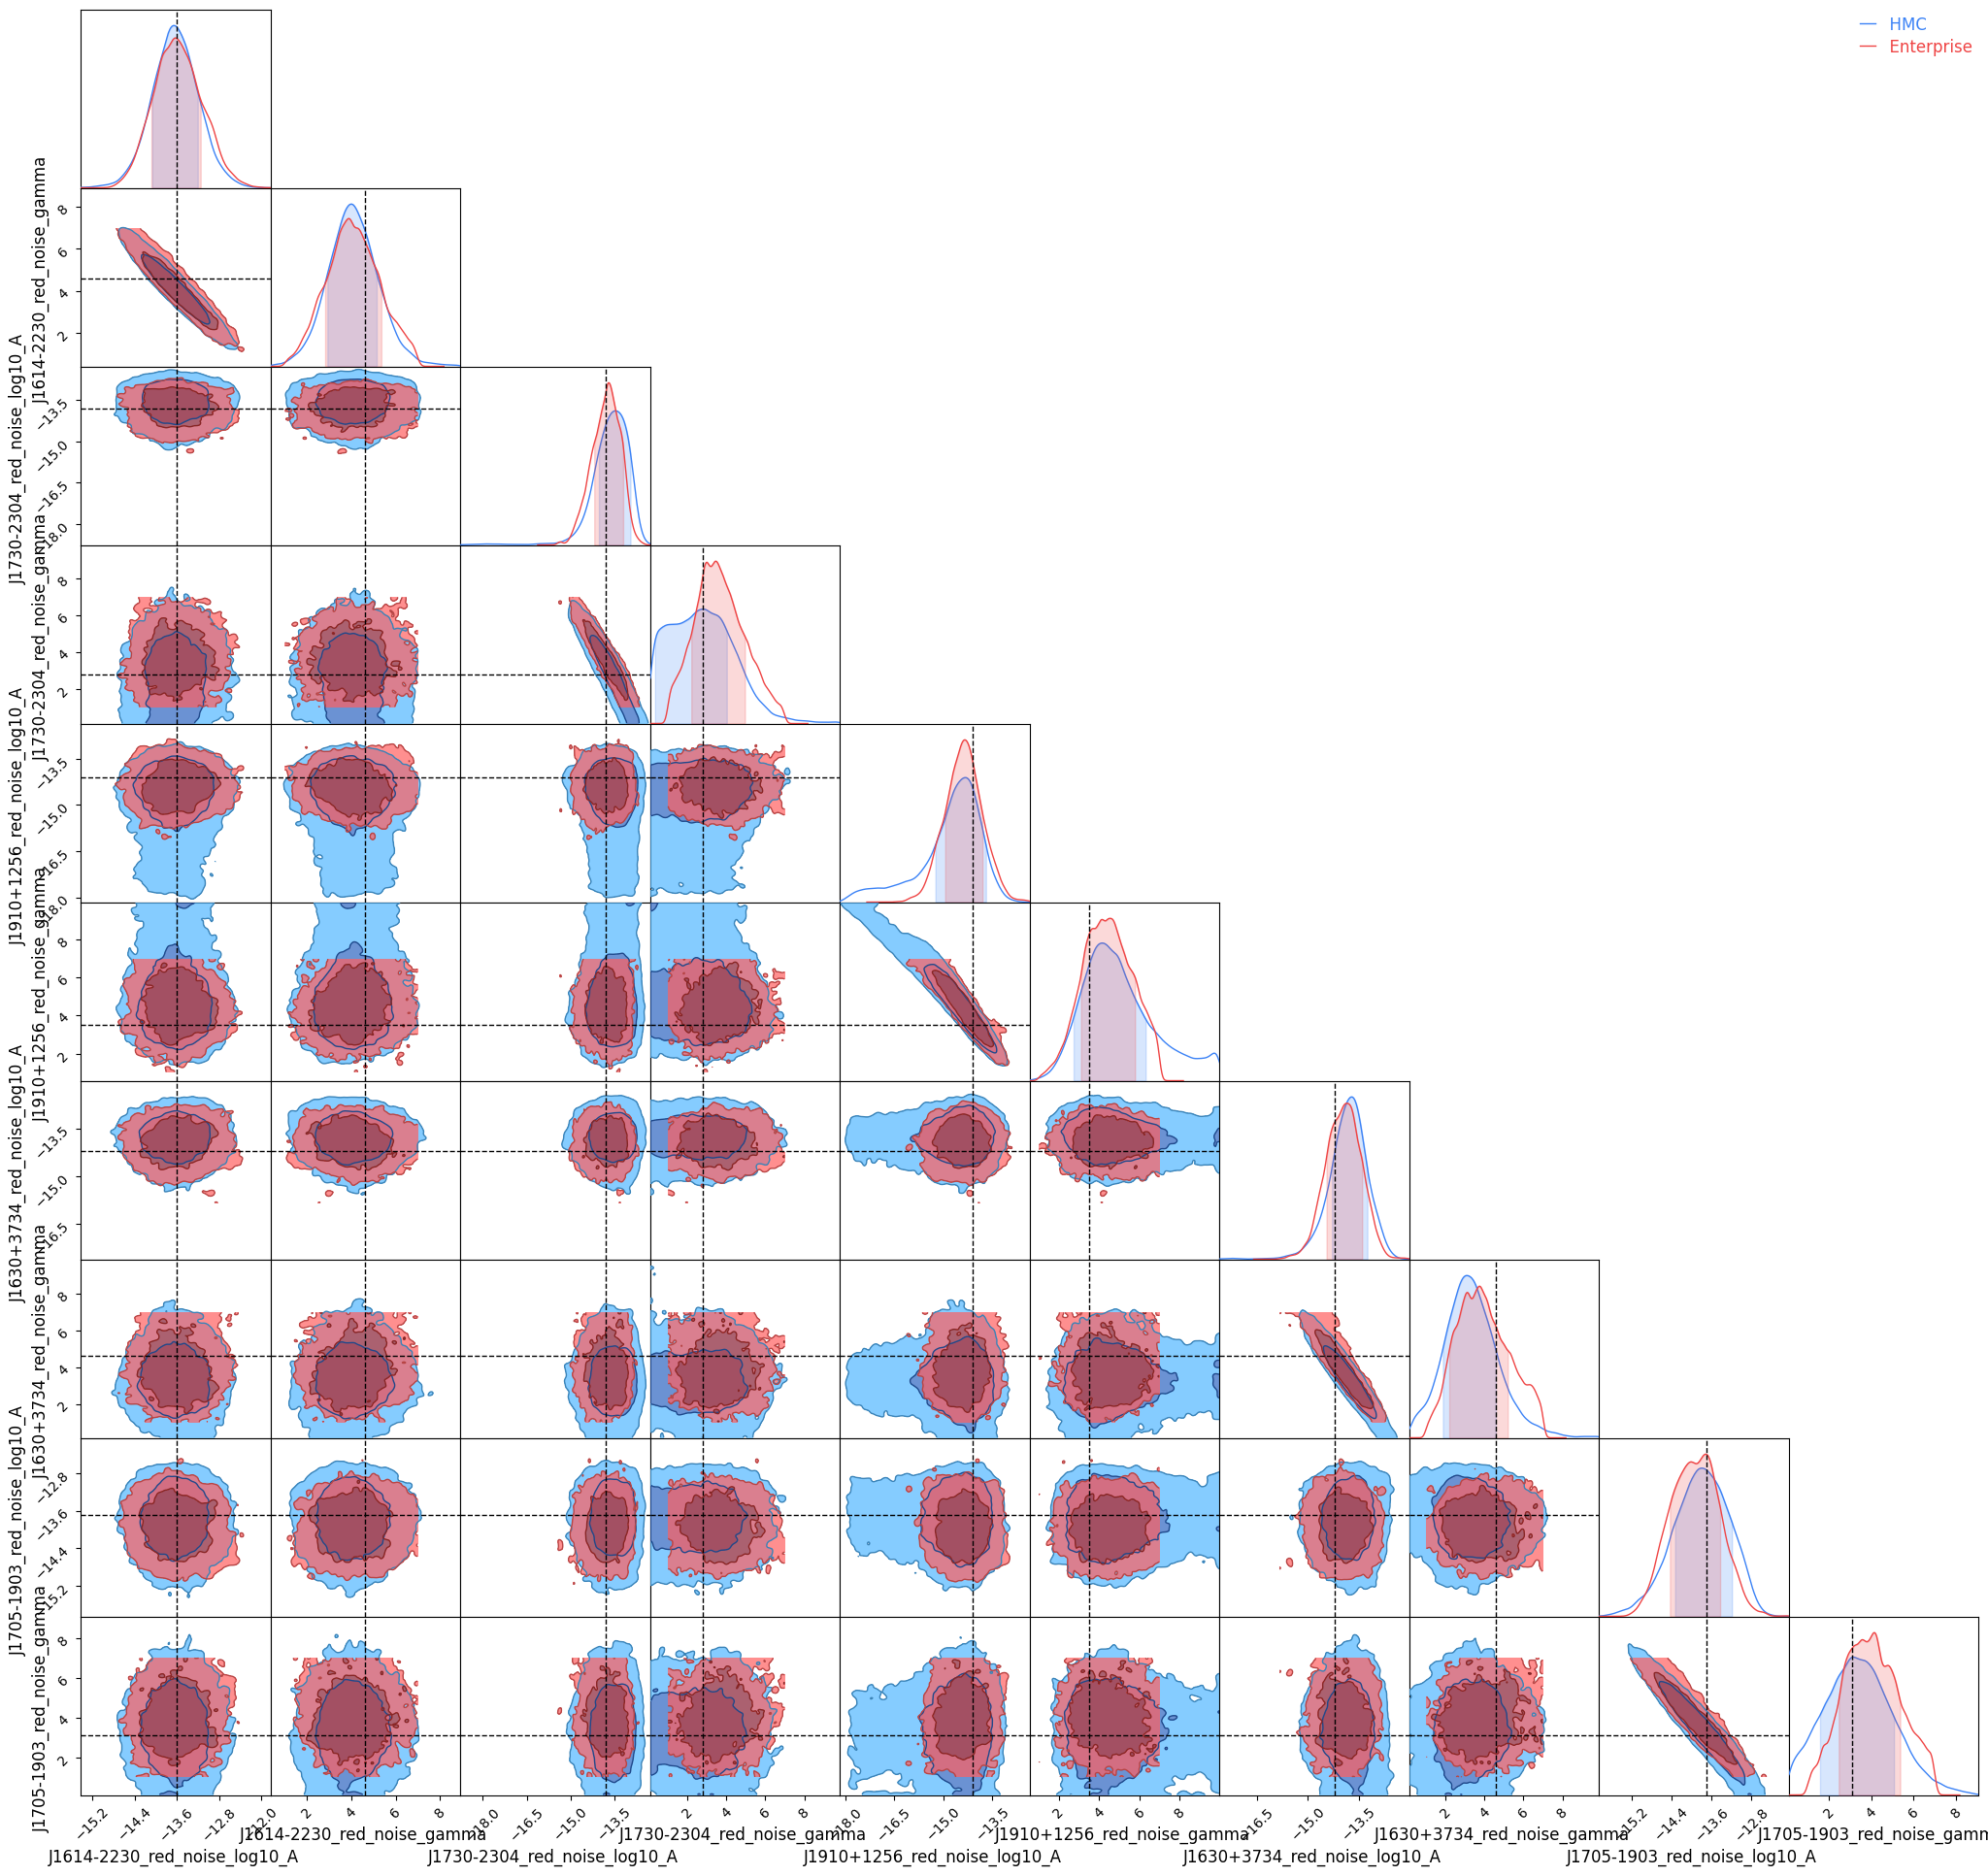

In [73]:
# red noise corner plot
ndxs = np.r_[:10]
rn_labels = np.array([[f'{psr_name}_red_noise_log10_A', f'{psr_name}_red_noise_gamma']
                      for psr_name in psr_names]).flatten()
rn_df = pd.DataFrame(hmc_samples.samples[:, pta_for_params.rn_ndxs], columns=rn_labels)
# ent_df = pd.DataFrame(ent_samples_dict)
c = ChainConsumer()
c.add_chain(Chain(samples=rn_df[rn_labels[ndxs]], name='HMC', color='blue'))
c.add_chain(Chain(samples=ent_df[rn_labels[ndxs]], name='Enterprise', color='red'))
c.add_truth(Truth(location=x_inj_dict))
fig = c.plotter.plot()

Parameter cw_log10_Mc in chain HMC is not constrained
Parameter cw_cosinc in chain HMC is not constrained
Parameter cw_cosinc in chain Enterprise is not constrained
Parameter cw_psi in chain HMC is not constrained
Parameter cw_psi in chain Enterprise is not constrained
Parameter cw_phase0 in chain Enterprise is not constrained


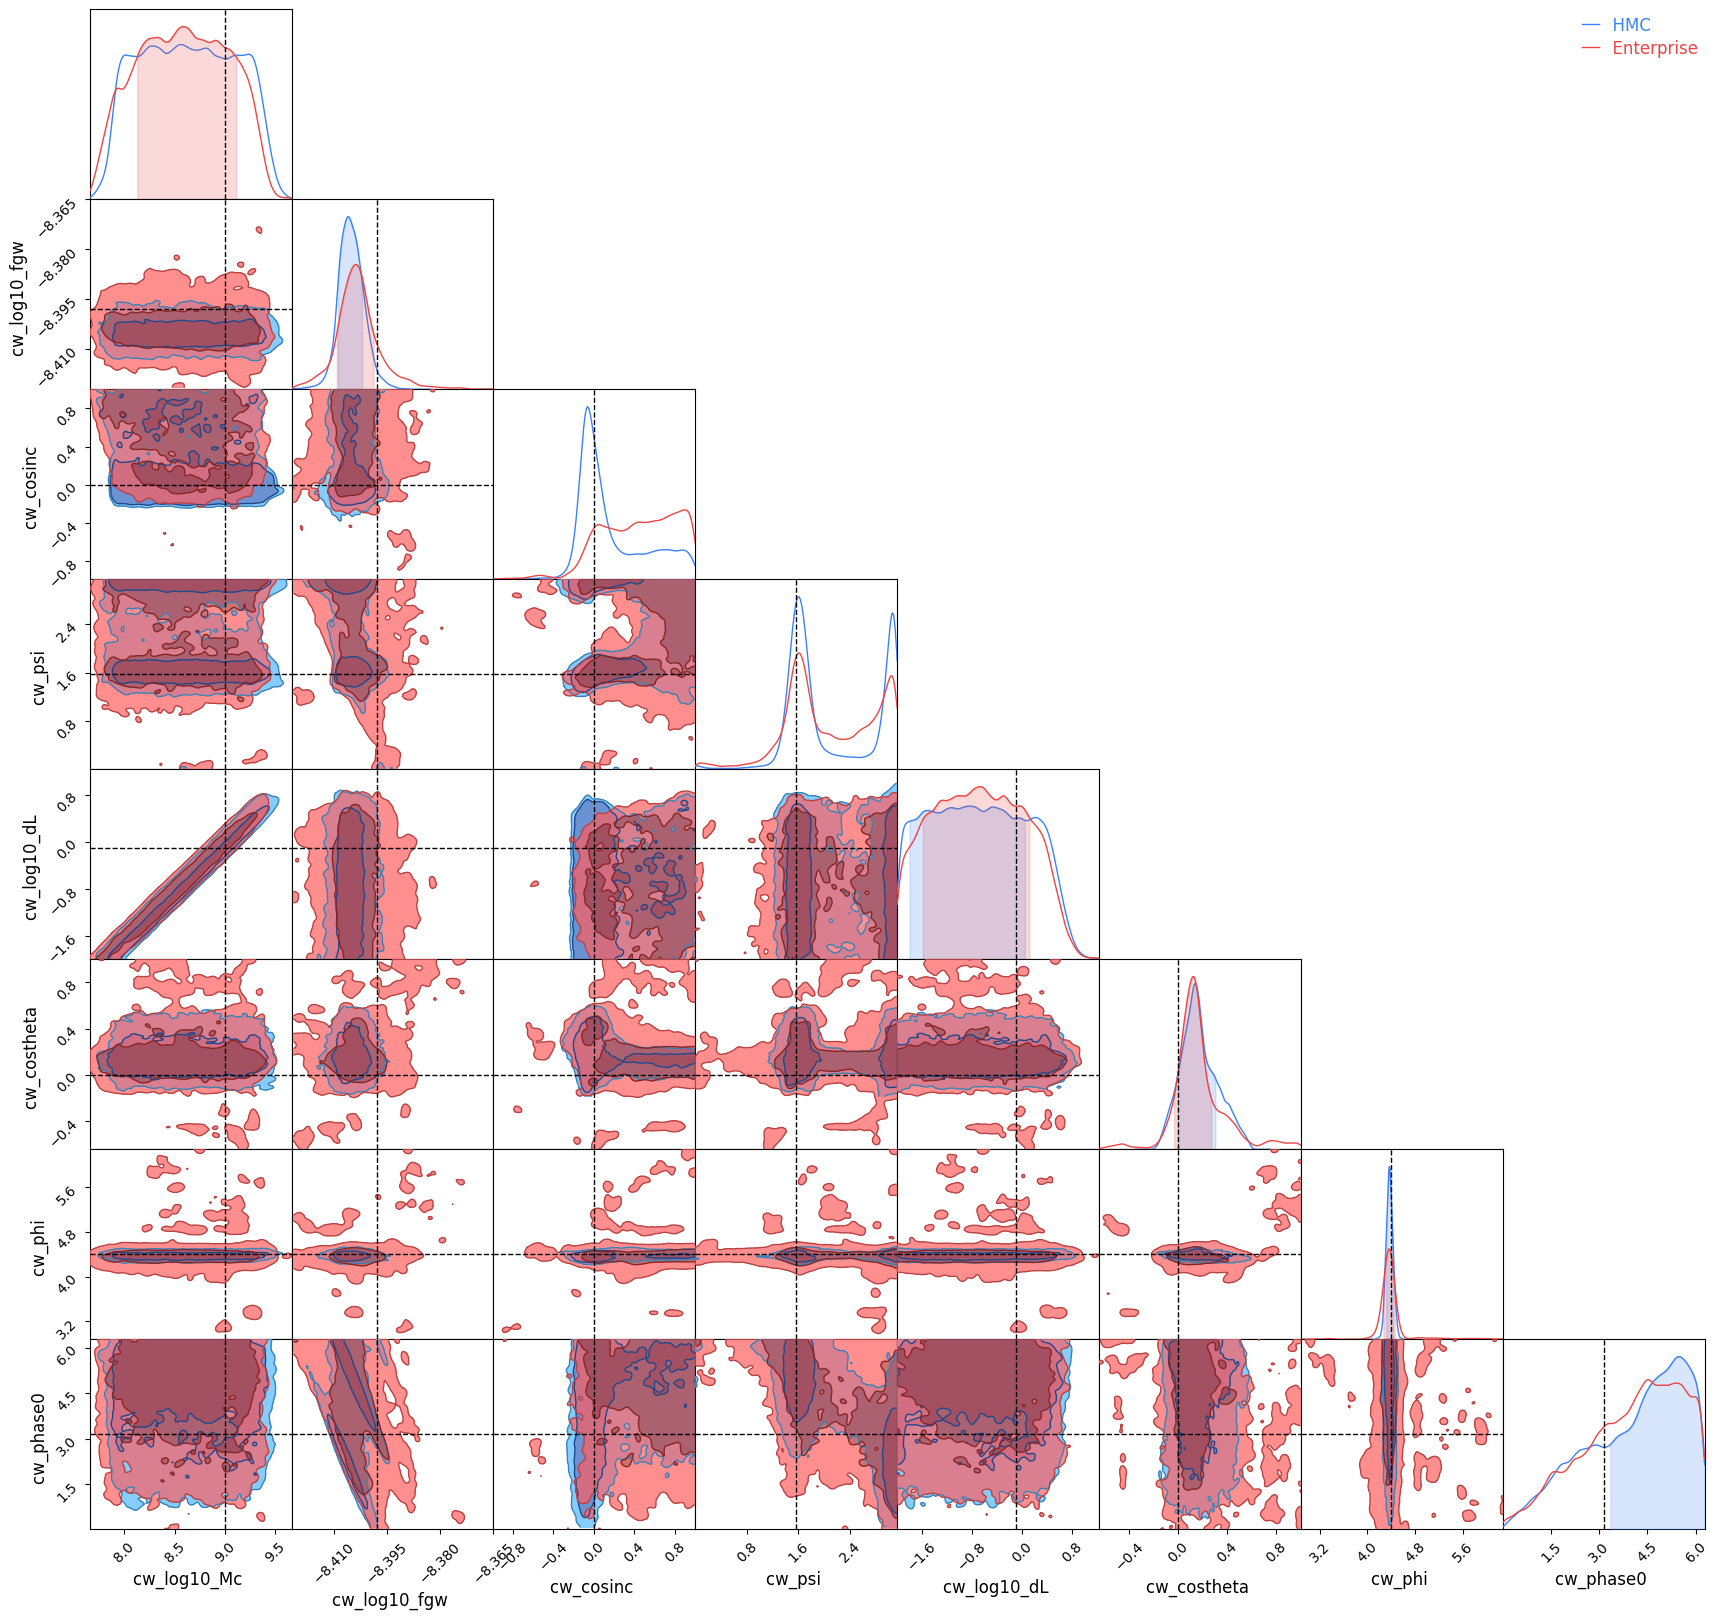

In [74]:
# CW corner plot
ndxs = np.r_[:8]
cw_labels = np.array(['cw_log10_Mc', 'cw_log10_fgw', 'cw_cosinc', 'cw_psi',
                      'cw_log10_dL', 'cw_costheta', 'cw_phi', 'cw_phase0'])
cw_df = pd.DataFrame(hmc_samples.samples[:, pta_for_params.cw_ndxs], columns=cw_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=cw_df[cw_labels[ndxs]], name='HMC', color='blue'))
c.add_chain(Chain(samples=ent_df[cw_labels[ndxs]], name='Enterprise', color='red'))
c.add_truth(Truth(location=x_inj_dict))
fig = c.plotter.plot()